In [1]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# --- Detailed Gym Docs with Metadata + Timings ---
docs = [
    Document(
        page_content="""
Morning Yoga Class: 6:00 AM - 7:00 AM.
This session focuses on improving flexibility, mindfulness, and breathing control. 
It begins with a 10-minute warm-up, followed by sun salutations, balance poses, and guided meditation. 
Perfect for beginners and advanced yogis alike, this class helps reduce stress and energize you for the day ahead.
""",
        metadata={"source": "yoga_file.txt"}
    ),
    Document(
        page_content="""
Strength Training: 7:30 AM - 9:00 AM.
This class emphasizes building muscle strength and endurance through weight lifting, kettlebell swings, and resistance band exercises. 
The workout is divided into circuits: chest and back on Mondays, legs and shoulders on Wednesdays, and full-body compound lifts on Fridays. 
Each session includes a 15-minute cooldown with stretches to prevent injury.
""",
        metadata={"source": "strength_file.txt"}
    ),
    Document(
        page_content="""
Cardio Blast: 5:00 PM - 6:00 PM.
A high-intensity cardio class designed to improve stamina and burn fat quickly. 
Workouts include treadmill sprints, rowing machine intervals, cycling bursts, and jump rope challenges. 
The class alternates between 1-minute high intensity and 30-second rest periods. 
Recommended for those looking to lose weight and build endurance after work hours.
""",
        metadata={"source": "cardio_file.txt"}
    ),
    Document(
        page_content="""
Evening Zumba: 6:30 PM - 7:30 PM.
A dance-based fitness class featuring Latin music and fast-paced choreography. 
This fun session is structured with warm-up routines, high-energy dance sequences, and a cooldown stretch. 
It is ideal for anyone wanting to burn 500–700 calories in one session while enjoying music. 
No prior dance experience required. Perfect way to end the day with energy and positivity.
""",
        metadata={"source": "zumba_file.txt"}
    ),
    Document(
        page_content="""
Gym Facilities and Closing Hours:
Our gym is open daily from 5:30 AM to 10:00 PM. 
We provide a sauna and steam room facility, available from 8:00 PM to 9:30 PM for relaxation and muscle recovery. 
The gym also includes a protein shake bar that operates from 7:00 AM to 9:00 AM in the morning and 6:00 PM to 8:00 PM in the evening. 
Personal trainers are available between 6:00 AM to 9:00 AM and 5:00 PM to 8:00 PM for customized guidance.
""",
        metadata={"source": "facilities_file.txt"}
    ),
    Document(
        page_content="""
Nutrition & Diet Guidance:
Daily consultation timings are from 10:00 AM - 12:00 PM. 
Our certified dietitians provide personalized diet charts based on your fitness goals. 
For weight loss, the plan emphasizes high-protein breakfasts, low-carb lunches, and balanced dinners. 
For muscle gain, it includes post-workout protein shakes, calorie-dense snacks, and proper hydration strategies. 
Weekly diet follow-up sessions are scheduled every Friday at 11:00 AM.
""",
        metadata={"source": "nutrition_file.txt"}
    )
]

db = Chroma.from_documents(docs, embedding_function)

C:\Users\el-noir\AppData\Local\Temp\ipykernel_12716\611525320.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
d:\AI\Langgraph-practice\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
retriever = db.as_retriever(search_type="mmr", search_kwargs={"k":3})

In [3]:
retriever.invoke("Who is the owner and what are the timings")

[Document(metadata={'source': 'nutrition_file.txt'}, page_content='\nNutrition & Diet Guidance:\nDaily consultation timings are from 10:00 AM - 12:00 PM. \nOur certified dietitians provide personalized diet charts based on your fitness goals. \nFor weight loss, the plan emphasizes high-protein breakfasts, low-carb lunches, and balanced dinners. \nFor muscle gain, it includes post-workout protein shakes, calorie-dense snacks, and proper hydration strategies. \nWeekly diet follow-up sessions are scheduled every Friday at 11:00 AM.\n'),
 Document(metadata={'source': 'cardio_file.txt'}, page_content='\nCardio Blast: 5:00 PM - 6:00 PM.\nA high-intensity cardio class designed to improve stamina and burn fat quickly. \nWorkouts include treadmill sprints, rowing machine intervals, cycling bursts, and jump rope challenges. \nThe class alternates between 1-minute high intensity and 30-second rest periods. \nRecommended for those looking to lose weight and build endurance after work hours.\n'),
 

In [4]:
from langchain_core.prompts import ChatPromptTemplate

template = """
Answer the question based only on the following context: {context}
Question: {question}"""

prompt = ChatPromptTemplate.from_template(template, role="human")

print(prompt)

input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='\nAnswer the question based only on the following context: {context}\nQuestion: {question}'), additional_kwargs={})]


In [5]:
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
from langchain_core.runnables import RunnableParallel

load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY")
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm

In [6]:
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain.schema import Document
from langgraph.graph import add_messages, StateGraph, END

class AgentState(TypedDict):
    messages: list[BaseMessage]
    documents: list[Document]
    on_topic: str

In [23]:
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
import os
from dotenv import load_dotenv

load_dotenv()

class GradeQuestion(BaseModel):
    """Boolean value to check whether a question is related to the Peak performance Gym"""

    scores: str = Field(
        description="Question is about gym? If yes -> 'Yes' if not 'No' "
    )

def question_classifier(state: AgentState):
    question = state["messages"][-1].content
    system = """ You are a classifier that determines where a user's question is about one ofthe following topics
    1. Gym History & Founder 
    2. Operation Hours
    3. Membership Plans
    4. Fitness Classes
    5. Personal Trainers
    6. Facilities & Equipment
    
    If the question is about any of these topics, respond with 'Yes'.
    Otherwise, respond with 'No'.
    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
        ("system", system),
        ("human", "User question: {question}")
       ]
    )

    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    state["on_topic"] = result.scores

    return state


In [24]:
def on_topic_router(state: AgentState):
    on_topic = state["on_topic"]
    if on_topic.lower() =="yes":
        return "on_topic"
    return "off_topic"

def retrieve(state: AgentState):
    question = state["messages"][-1].content
    documents = retriever.invoke(question)
    state["documents"] = documents
    return state

def generate_answer(state: AgentState):
    question = state["messages"][-1].content
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question": question})
    state["messages"].append(generation)

def off_topic_response(state: AgentState):
    state["messages"].append(AIMessage(content="I'm sorry! I cannot answer this question"))
    return state


In [25]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate_answer", generate_answer)

workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve",
        "off_topic": "off_topic_response"
    }
)

workflow.add_edge("retrieve", "generate_answer")
workflow.add_edge("generate_answer", END)
workflow.add_edge("off_topic_response", END)

workflow.set_entry_point("topic_decision")
graph = workflow.compile()


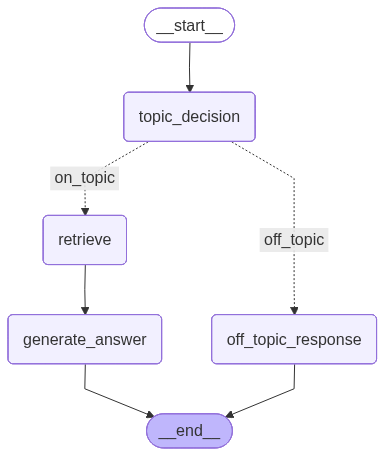

In [26]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [28]:
graph.invoke(input={
    "messages": [HumanMessage(content="what are the timings?")]
})

{'messages': [HumanMessage(content='what are the timings?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Cardio Blast: 5:00 PM - 6:00 PM\nDaily consultation: 10:00 AM - 12:00 PM\nWeekly diet follow-up sessions: every Friday at 11:00 AM\nEvening Zumba: 6:30 PM - 7:30 PM', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--af84f330-ce87-44e6-8c17-7ddc6beeeb50-0', usage_metadata={'input_tokens': 383, 'output_tokens': 71, 'total_tokens': 454, 'input_token_details': {'cache_read': 0}})],
 'documents': [Document(metadata={'source': 'cardio_file.txt'}, page_content='\nCardio Blast: 5:00 PM - 6:00 PM.\nA high-intensity cardio class designed to improve stamina and burn fat quickly. \nWorkouts include treadmill sprints, rowing machine intervals, cycling bursts, and jump rope challenges. \nThe class alternates between 1-minute high int